Written by AI22BTECH11005

In [ ]:
# %pip install shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shap
import matplotlib.pyplot as plt
import numpy as np


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## To note that normalisation is not done as SHAP heatmaps give strange intensity values because of this 

In [2]:
import torch
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor()
])


# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the lengths for training and validation sets
train_size = int(0.7 * len(full_train_dataset))
val_size = int(0.1 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, _ = torch.utils.data.random_split(full_train_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader)) 

1313 188 313


In [3]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )
        
        self.flatten = nn.Flatten()  # SHAP-friendly flattening
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation loss tracking
num_epochs = 3  # Set training epochs
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot training & validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Evaluate on test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

model.load_state_dict(torch.load("mnist_cnn_SHAP.pth"))

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"train Accuracy: {100 * correct / total:.2f}%")


# Evaluate on test data
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


train Accuracy: 98.51%
Test Accuracy: 98.46%


In [6]:
# # Save trained model
# torch.save(model.state_dict(), "mnist_cnn_SHAP.pth")
# print("Model saved as mnist_cnn_SHAP.pth")

In [7]:
# # Define wrapper
# class WrappedCNN(nn.Module):
#     def __init__(self, model):
#         super(WrappedCNN, self).__init__()
#         self.model = model
    
#     def forward(self, x):
#         return self.model(x)

# # Wrap your trained model
# wrapped_model = WrappedCNN(model)
# wrapped_model.eval()


In [8]:
# Pick background images (for approximating "missing features")
background_loader = torch.utils.data.DataLoader(train_loader.dataset, batch_size=100, shuffle=True)
background_images, _ = next(iter(background_loader))
background_images = background_images.to(device)

# Pick a few test images to explain
test_images, test_labels = next(iter(test_loader))
test_images = test_images[:10].to(device)  # Choose 5 images



# # Plot 25 images (5x5 grid)
# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(background_images[i][0], cmap='gray')
#     plt.axis('off')
# plt.suptitle("Sample of Background Images for SHAP", fontsize=16)
# plt.show()


In [9]:
# Set model to evaluation mode
model.eval()

# Create SHAP explainer
explainer = shap.DeepExplainer(model, background_images)
shap_values = explainer.shap_values(test_images)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [10]:
# test_images_numpy = test_images.cpu().numpy()

# # Now plot
# shap.image_plot(shap_values, test_images_numpy)

In [11]:
# threshold = 0.05  # Change this number depending on how strict you want it

# # Step 2: Mask out weak pixels
# # shap_values is a list: one array for each output class (0 to 9)
# masked_shap_values = []

# for class_shap in shap_values:
#     # Copy to avoid changing original
#     class_shap_copy = np.copy(class_shap)
#     # Apply threshold: Keep only strong positive regions
#     class_shap_copy[np.abs(class_shap_copy) < threshold] = 0
#     masked_shap_values.append(class_shap_copy)

# # Step 3: Plot the masked SHAP values
# shap.image_plot(masked_shap_values, test_images_numpy)

In [12]:
# threshold = 0.1  # Change this number depending on how strict you want it

# # Step 2: Mask out weak pixels
# # shap_values is a list: one array for each output class (0 to 9)
# masked_shap_values = []

# for class_shap in shap_values:
#     # Copy to avoid changing original
#     class_shap_copy = np.copy(class_shap)
#     # Apply threshold: Keep only strong positive regions
#     class_shap_copy[np.abs(class_shap_copy) < threshold] = 0
#     masked_shap_values.append(class_shap_copy)

# # Step 3: Plot the masked SHAP values
# shap.image_plot(masked_shap_values, test_images_numpy)

In [13]:
# threshold = 0.02  # Change this number depending on how strict you want it

# # Step 2: Mask out weak pixels
# # shap_values is a list: one array for each output class (0 to 9)
# masked_shap_values = []

# for class_shap in shap_values:
#     # Copy to avoid changing original
#     class_shap_copy = np.copy(class_shap)
#     # Apply threshold: Keep only strong positive regions
#     class_shap_copy[np.abs(class_shap_copy) < threshold] = 0
#     masked_shap_values.append(class_shap_copy)

# # Step 3: Plot the masked SHAP values
# shap.image_plot(masked_shap_values, test_images_numpy)

In [15]:
test_images_numpy = test_images.cpu().numpy()

# shap.summary_plot(shap_values, test_images_numpy)


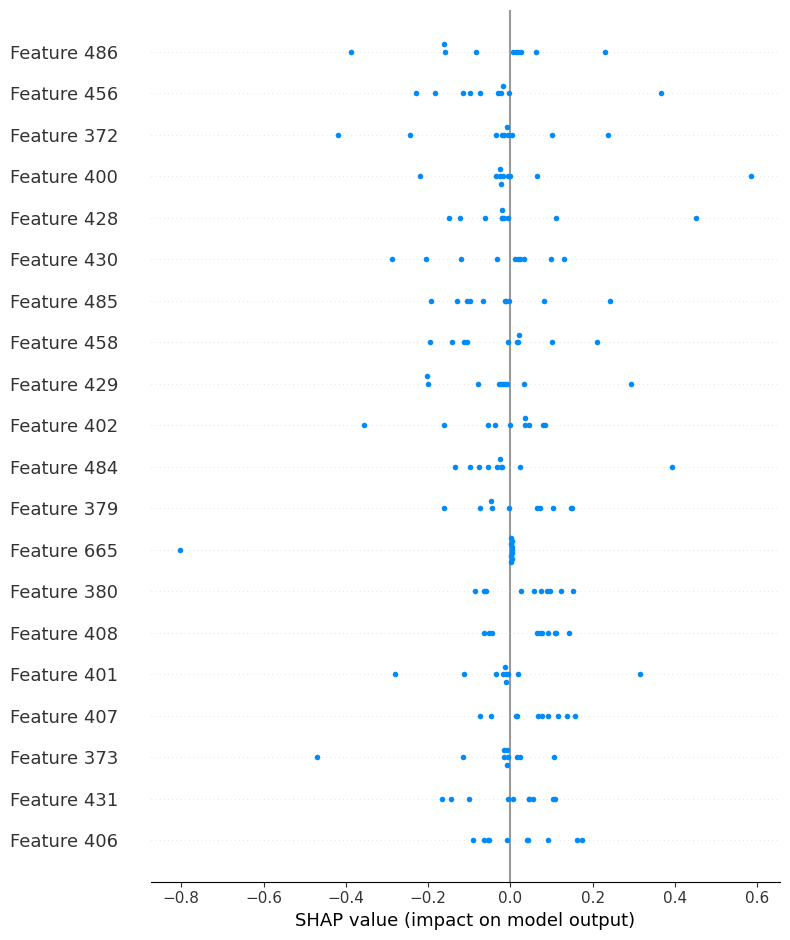

Important features effecting 0 class prediction and in which direction


In [27]:
# 1. Flatten SHAP values for one class (e.g., class 0)
shap_values_class0_flat = shap_values[0].reshape(shap_values[0].shape[0], -1)

# 2. Plot WITHOUT giving features
shap.summary_plot(shap_values_class0_flat)

print("Important features effecting 0 class prediction and in which direction")

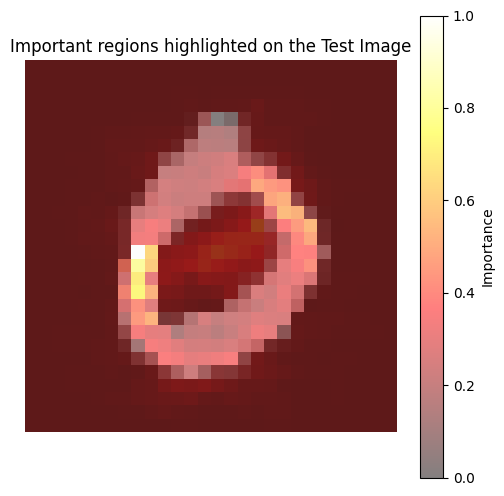

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 3

# Get SHAP values for the correct class
shap_img = shap_values[0][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


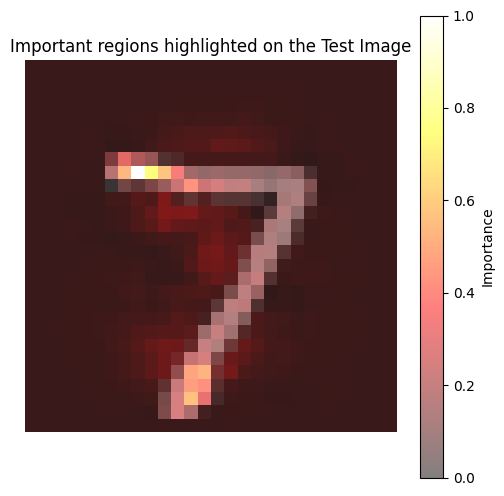

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 0

# Get SHAP values for the correct class
shap_img = shap_values[7][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


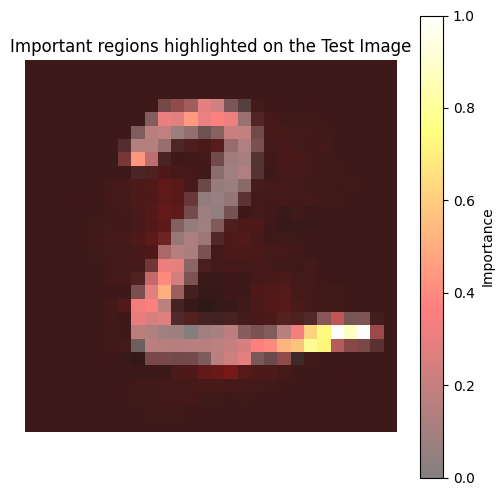

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 1

# Get SHAP values for the correct class
shap_img = shap_values[2][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


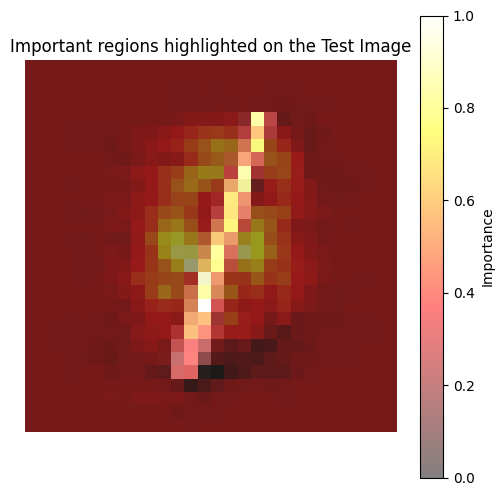

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 2

# Get SHAP values for the correct class
shap_img = shap_values[1][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


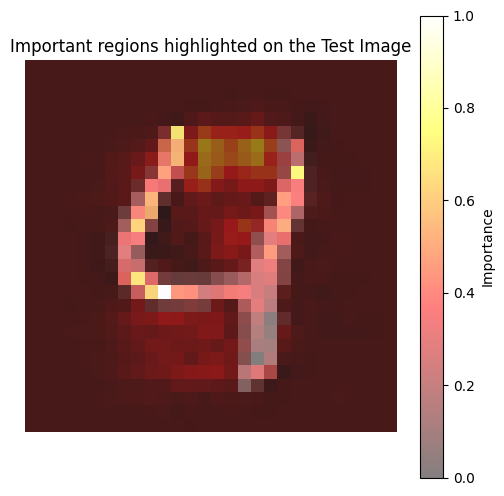

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 4

# Get SHAP values for the correct class
shap_img = shap_values[4][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


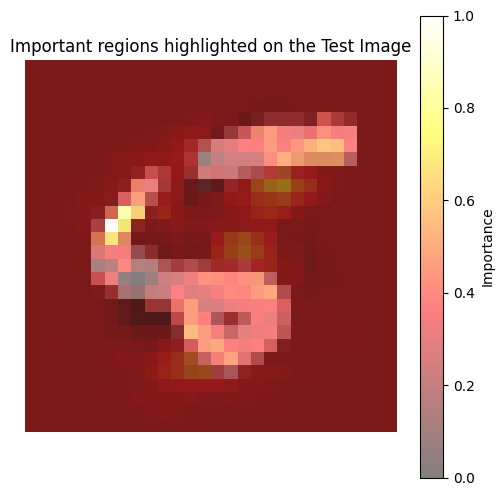

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 8

# Get SHAP values for the correct class
shap_img = shap_values[5][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


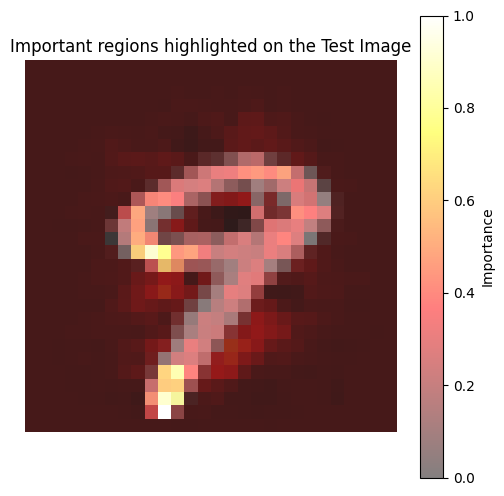

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume:
# - shap_values is already computed
# - test_images_numpy is available
test_images_numpy = test_images.cpu().numpy()
# Pick one test image (for example, the first one)
img_idx = 9

# Get SHAP values for the correct class
shap_img = shap_values[9][img_idx][0]  # class 0 shap values, first image

# Get original image
original_img = test_images_numpy[img_idx][0]  # shape (28,28)

# Normalize SHAP values for visualization
shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())

# Plot
plt.figure(figsize=(6,6))
plt.imshow(original_img, cmap='gray', alpha=0.8)  # original digit
plt.imshow(shap_img_norm, cmap='hot', alpha=0.5)   # SHAP heatmap overlaid
plt.colorbar(label='Importance')
plt.title("Important regions highlighted on the Test Image")
plt.axis('off')
plt.show()


In [ ]:
import shap
shap.initjs()

# Flatten and cast to float64
shap_value_flat = shap_values[0][0].reshape(-1).astype(np.float64)
test_image_flat = test_images_numpy[0].reshape(-1).astype(np.float64)

# Now call force plot
shap.force_plot(explainer.expected_value[0], shap_value_flat, test_image_flat)
